<a href="https://colab.research.google.com/github/aanchal0431/chatbot/blob/main/SEP_728_Chatbot_test_bert_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from sklearn.model_selection import train_test_split

In [ ]:
print(tf.__version__)

2.7.0


Git Commands to clone repository, pull and push data

In [ ]:
!git clone https://github.com/aanchal0431/chatbot.git
#!git pull
%cd chatbot/
#!git config --global user.name "aanchal0431"
#!git config --global user.email "aanchal0431@gmail.com"
#!git remote add aanchal0431 https://github.com/aanchal0431/chatbot.git
#!git --help
#!git remote -v
#!git init
#%ls
#!git add outputs/
!git status 
#!git commit -m 'Model epoch 1'


Cloning into 'chatbot'...
remote: Enumerating objects: 712, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 712 (delta 61), reused 178 (delta 35), pack-reused 486
Receiving objects: 100% (712/712), 7.18 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/chatbot
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


### Data Preprocessing - **Cleaning**

*   Load datasets
*   Append question and answer datasets
*   Remove questions with no answers
*   Drop irrelevant columns
*   Remove duplicate questions
*   Convert data to lower case
*   Add context

In [ ]:
cur_path = 'Data/Question_Answer_Dataset_v1.2/'
data_s8 = pd.read_csv(cur_path + 'S08/question_answer_pairs.txt', delimiter="\t")
data_s9 = pd.read_csv(cur_path + 'S09/question_answer_pairs.txt', delimiter="\t")
data_s10 = pd.read_csv(cur_path + 'S10/question_answer_pairs.txt', delimiter="\t")
print("Shape s8:", data_s8.shape)
print("Shape s9:", data_s9.shape)
print("Shape s10:", data_s10.shape)
data_s8.head()

Shape s8: (1715, 6)
Shape s9: (825, 6)
Shape s10: (1458, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Append Data

In [ ]:
#append all questions into one data set
data_all = data_s8.append(data_s9.append(data_s10))
print("Shape:", data_all.shape)
data_all.head()


Shape: (3998, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Drop irrelevant columns and remove questions without an answer

In [ ]:
#remove irrelevant columns
data_all = data_all.drop(labels = ['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], axis = 1)

#drop rows with NULL values
data_all = data_all.dropna(subset=['Answer'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (3422, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Abraham_Lincoln,Did his mother die of pneumonia?,no


Remove duplicate questions

In [ ]:
#remove duplicate questions
data_all = data_all.drop_duplicates(subset=['Question'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (2203, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
4,Abraham_Lincoln,Did his mother die of pneumonia?,no
6,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months
8,Abraham_Lincoln,When did Lincoln begin his political career?,1832


Convert all text to lower case

In [ ]:
# convert text to lower case
data_all = data_all.apply(lambda x: x.astype(str).str.lower())
data_all.head()

,ArticleTitle,Question,Answer
0,abraham_lincoln,was abraham lincoln the sixteenth president of...,yes
2,abraham_lincoln,did lincoln sign the national banking act of 1...,yes
4,abraham_lincoln,did his mother die of pneumonia?,no
6,abraham_lincoln,how many long was lincoln's formal education?,18 months
8,abraham_lincoln,when did lincoln begin his political career?,1832


Load Wikipedia article and add to the dataframe

In [ ]:
#Add a column containing the context
#create dataset with column
title = []
context = []

#pull context and titles from S08
for y in range (8, 11):   
  for s in range(1, 7):
    for a in range(1, 11):
      file = str('Data/Question_Answer_Dataset_v1.2/S0' + str(y) + '/data/set' + str(s) + '/a' + str(a) + '.txt.clean' )
      if os.path.exists(file):
        article = open(file, encoding = "ISO-8859-1").read()
        context.append(article)
        title.append(article.split('\n')[0])

#create dataframe for context and titles
data_articles = pd.DataFrame({'ArticleTitle': title,
                              'Context': context})

#make lower case
data_articles = data_articles.apply(lambda x: x.astype(str).str.lower())

print("Shape:", data_articles.shape)
data_articles.head()

Shape: (90, 2)


,ArticleTitle,Context
0,kangaroo,kangaroo\n\n\na kangaroo is a marsupial from t...
1,leopard,leopard\n\n\n\nthe leopard (panthera pardus) i...
2,penguin,penguin\n\n\n\na penguin encounters a human du...
3,polar bear,polar bear\n\n\n\nthe polar bear (ursus mariti...
4,elephant,elephant\n\n\n\nelephants (elephantidae) are a...


In [ ]:
#replace all _ in titles with spaces
data_all['ArticleTitle'] = data_all['ArticleTitle'].str.replace('_', ' ')
data_articles['ArticleTitle'] = data_articles['ArticleTitle'].str.replace('_', ' ')

#join context into data all
data_all = data_all.merge(data_articles, how='left', on='ArticleTitle')

print("Shape:", data_all.shape)
data_all.head()

Shape: (2755, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...


### Explore Data
Check the word length of the answers. How many questions are yes/no questions? What type of question is asked most often?

Single word answers: 1575
Two word answers: 231
Three word answers: 161
Four word answers: 124
Five word answers: 88
6-10 word answers: 341
11-20 word answers: 186
More than 20 words answers: 49

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

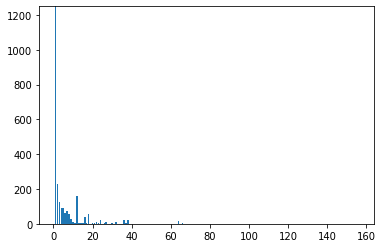

In [ ]:
#plot the distribution of answer word length
word_length = data_all['Answer'].str.count(' ') + 1
string_length = data_all['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,1250])
plt.show

In [ ]:
#examine types of questions
question_type = data_all['Question'].str.split(' ').str[0]
question_type.value_counts()

what      564
is        395
was       247
how       196
did       193
         ... 
with        1
adams       1
hassan      1
qatar       1
sibiu,      1
Name: Question, Length: 102, dtype: int64

In [ ]:
#pull all yes/no questions
yes_no = ['yes', 'yes.', 'yes,', 'no', 'no.', 'no,']
data_yn = data_all.where(data_all['Answer'].str.split(' ').str[0].isin(yes_no)).dropna()
data_yn['Answer'] = data_yn['Answer'].str.split(' ').str[0]

#remove periods & commas
data_yn['Answer'] = data_yn['Answer'].str.replace('.','')
data_yn['Answer'] = data_yn['Answer'].str.replace(',','')

print("Shape:", data_yn.shape)
data_yn.head()

Shape: (1070, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...


In [ ]:
#pull all other questions that pull "direct" answers from the context
data_context = data_all.where((data_all['Answer'].str.split(' ').str[0].isin(yes_no)) == False).dropna()
data_context.to_csv('Questions_toClean.csv', index=False)
print("Shape:", data_context.shape)
data_context.head()

Shape: (1252, 4)


,ArticleTitle,Question,Answer,Context
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...
5,abraham lincoln,what did the legal tender act of 1862 establish?,"the united states note, the first paper curren...",abraham lincoln\n\n\n\nabraham lincoln (februa...
6,abraham lincoln,who suggested lincoln grow a beard?,11-year-old grace bedell,abraham lincoln\n\n\n\nabraham lincoln (februa...
7,abraham lincoln,when did the gettysburg address argue that ame...,1776,abraham lincoln\n\n\n\nabraham lincoln (februa...


Single word answers: 363
Two word answers: 197
Three word answers: 141
Four word answers: 99
Five word answers: 69
6-10 word answers: 236
11-20 word answers: 116
More than 20 words answers: 31

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

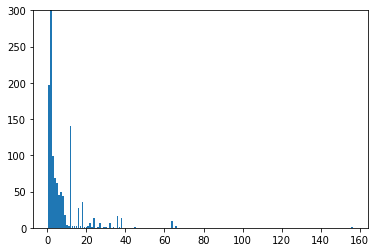

In [ ]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Answer'].str.count(' ') + 1
string_length = data_context['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,300])
plt.show

In [ ]:
#create type indicator in data set and combine clean yes/no and context
data_yn['Answer Type'] = 'yes/no'
data_context['Answer Type'] = 'context'
data_all = data_yn.append(data_context)

print("Shape:", data_all.shape)
data_all.head()

Shape: (2322, 5)


,ArticleTitle,Question,Answer,Context,Answer Type
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no


### Data Preprocess - Model preparation

In [ ]:
#Tokenization Example for Questions
# import APIs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# segregating questions and answers into different lists
questions = list(data_all['Question'])
answers = list(data_all['Answer'])

#initialize the tokenizer
tokenizer = Tokenizer(oov_token="<oov>") #oov: out of vocabulary token => used to handle newly encountered words in the training dataset, new

#creating word index
tokenizer.fit_on_texts(questions)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#create sequences using tokenizer
sequences = tokenizer.texts_to_sequences(questions)

#padding the sequences to make sure length matches for all the sequences
padded_sequences_questions = pad_sequences(sequences, padding='pre')

print("Vocabulary size for questions:", vocab_size)
#print(word_index)
#print(sequences)
print(padded_sequences_questions.shape)


Vocabulary size for questions: 3515
(2322, 43)


In [ ]:
#Tokenization Example for Answers

#creating word index
tokenizer.fit_on_texts(answers)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#create sequences using tokenizer
sequences = tokenizer.texts_to_sequences(answers)

#padding the sequences to make sure length matches for all the sequences
padded_sequences_answers = pad_sequences(sequences, padding='pre')

print("Vocabulary size for questions:", vocab_size)
#print(word_index)
#print(sequences)
print(padded_sequences_answers.shape)


Vocabulary size for questions: 4567
(2322, 156)


In [ ]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(data_s8['Question'], data_s8['Answer'],
          shuffle=True, test_size=0.1, random_state=5)


In [ ]:
#Format for simpleT5
train = pd.DataFrame({'source_text': X_train, 'target_text': y_train})
# Add prefix for simpleT5
#train['source_text']    = "answer question:" + train['source_text']
test = pd.DataFrame({'source_text': X_test, 'target_text': y_test}) 
#test['source_text']    = "answer question:" + test['source_text']
train.head()

,source_text,target_text
1214,Are otters playful animals?,yes
123,Did the scientific community not reserve great...,yes
1084,How many municipalities are within Oberland?,6.
917,What information did he record in his diary?,He wrote descriptions of events and impression...
823,"What does ""Era of Good Feelings"" refers to?","Monroe allowed his political base to decay, wh..."


In [ ]:
!pip install transformers

import torch

from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)
    print(input_ids)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')


import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)


answer_yn = data_yn['Answer'].tolist()
answer_context = data_context['Answer'].tolist()
print(answer_context)

text = ''
i = 1
for word in answer_context:
  if word != ',':
        text= text+word
        i = i+1
        if i == 70:
          break

text = text.replace(',', '')
text = text.replace(' ', '')
#print(text)

question = "when did lincoln begin his political career?"
test = "Abraham Lincoln (February 12, 1809 – April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, [I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now. This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Team of Rivals: The Political Genius of Abraham Lincoln (2005) p. 91.  Holzer pg. 232.  Writing of the Cooper Union  speech, Holzer notes, Cooper Union proved a unique confluence of political culture, rhetorical opportunity, technological innovation, and human genius, and it brought Abraham Lincoln to the center stage of American politics at precisely the right time and place, and with precisely the right message: that slavery was wrong, and ought to be confined to the areas where it already existed, and placed on the course of ultimate extinction... .  Lincoln won the Republican Party nomination in 1860 and was elected president later that year. During his term, he helped preserve the United States by leading the defeat of the secessionist Confederate States of America in the American Civil War. He introduced measures that resulted in the abolition of slavery, issuing his Emancipation Proclamation in 1863 and promoting the passage of the Thirteenth Amendment to the Constitution in 1865.Lincoln closely supervised the victorious war effort, especially the selection of top generals, including Ulysses S. Grant. Historians have concluded that he handled the factions of the Republican Party well, bringing leaders of each faction into his cabinet and forcing them to cooperate. Lincoln successfully defused a war scare with the United Kingdom in 1861. Under his leadership, the Union took control of the border slave states at the start of the war. Additionally, he managed his own reelection in the 1864 presidential election.Opponents of the war (also known as Copperheads) criticized him for refusing to compromise on the slavery issue. Conversely, the Radical Republicans, an abolitionist faction of the Republican Party, criticized him for moving too slowly in abolishing slavery. Even with these problems, Lincoln successfully rallied public opinion through his rhetoric and speeches; his Gettysburg Addres is but one example of this."
answer_question(question, test)





We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

### Train a Simple Model
A pretrained t5 model is used to test the question/answer process. No tokenization or context is required for this model.

In [ ]:
pip install --upgrade simplet5

     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 2.8 MB 60.0 MB/s 
     |████████████████████████████████| 919 kB 66.0 MB/s 
     |████████████████████████████████| 132 kB 46.2 MB/s 
     |████████████████████████████████| 596 kB 57.2 MB/s 
     |████████████████████████████████| 829 kB 58.4 MB/s 
     |████████████████████████████████| 329 kB 52.9 MB/s 
     |████████████████████████████████| 3.3 MB 16.2 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 73.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.5 MB/s 
     |████████████████████████████████| 160 kB 71.8 MB/s 
     |████████████████████████████████| 192 kB 59.5 MB/s 
     |████████████████████████████████| 271 kB 67.6 MB/s 
  Created wheel for simplet5: filename=simplet5-0.1.3-py3-none-any.whl size=6831 sha256=765e4c56a358d16431300053b0ef8d7e65d9df8c48f26e566f335d56fa7f84fa
  Stored in directory: /root/.cache/pi

In [ ]:
# import
from simplet5 import SimpleT5


# instantiate
model = SimpleT5()

# load (supports t5, mt5, byT5 models)
model.from_pretrained("t5","t5-base")

# train
model.train(train_df=train.applymap(str), # pandas dataframe with 2 columns: source_text & target_text
            eval_df=test.applymap(str), # pandas dataframe with 2 columns: source_text & target_text
            source_max_token_len = 132, #Issue: not sure of max len - 512
            target_max_token_len = 72, #Issue: not sure of max len - 128
            batch_size = 8,
            max_epochs = 2,
            use_gpu = False,
            #outputdir = '/model/simpleT5',
            early_stopping_patience_epochs = 0,
            )

Global seed set to 42


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# load trained T5 model
model.load_model("t5",'outputs/simplet5-epoch-1-train-loss-2.357', use_gpu=False)
# for each test data perform prediction
#model.predict("Did Lincoln start his political career in 1832?") #Should predict yes
#model.predict("When did the Gettysburg address argue that America was born?") #Should predict 1776, predicts 1815
model.predict("Who is most noted for his contributions to the theory of molarity and molecular weight?") # Should predict Amedeo Avogadro

['He is most noted for his contributions to the theory of molarity and molecular weight']

### BERT
Use a pretrained transformer model. Model inputs include the question and context. The model hones in on the relevant context for the answer. It does not provide a yes/no answer. It also is limited by the size of the context. Our context needs to be shortened to use Bert.

In [ ]:
!pip install transformers

from transformers import BertTokenizer, AutoTokenizer, BertForQuestionAnswering, AutoModelForQuestionAnswering
import torch

     |████████████████████████████████| 3.1 MB 15.4 MB/s 
     |████████████████████████████████| 596 kB 67.2 MB/s 
     |████████████████████████████████| 3.3 MB 60.4 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 61.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def Chatbot(question, context, model, tokenizer):

  #encode
  inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt')
  input_ids = inputs["input_ids"].tolist()[0]

  #tokenize
  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  #submit inputs to model
  outputs = model(**inputs)

  #get likelihood score of start and end
  answer_start_scores=outputs.start_logits
  answer_end_scores=outputs.end_logits

  #select most likely start and end
  answer_start = torch.argmax(answer_start_scores)  
  answer_end = torch.argmax(answer_end_scores) + 1

  #convert text between start and end back to text
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

  #return answer
  print('Chatbot Answer:', answer)
  return answer




Test on Questions

In [ ]:
#create list for question, context, and answer
question_yn = data_yn['Question'].tolist()
context_yn = data_yn['Context'].tolist()
answer_yn = data_yn['Answer'].tolist()

question_context = data_context['Question'].tolist()
context_context = data_context['Context'].tolist()
answer_context = data_context['Answer'].tolist()

In [ ]:
#BERT
BERT_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
BERT_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad') 

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [ ]:
#Ask three yes/no questions
for i in [1,30,300]:
    print('Question:', question_yn[i])
    print('Human answer:', answer_yn[i])

    #ask the chatbot
    Chatbot(question_yn[i], context_yn[i][0:512], BERT_model, BERT_tokenizer)

    print('\n')

Question: did lincoln sign the national banking act of 1863?
Human answer: yes
Chatbot Answer: national banking act of 1863


Question: is it true that he published a collection in 1738?
Human answer: no
Chatbot Answer: at nuremberg in 1733


Question: do sea otters have long muscular tails?
Human answer: no
Chatbot Answer: otter otters are semi - aquatic ( or in one case aquatic ) fish - eating mammals . the otter subfamily lutrinae forms part of the family mustelidae , which also includes weasels , polecats , badgers , as well as others . with thirteen species in seven genera , otters have an almost worldwide distribution . they mainly eat aquatic animals , predominantly fish and shellfish , but also other invertebrates , amphibians , birds and small mammals . the word otter




In [ ]:
#Ask three context questions
for i in [1,30,300]:
    print('Question:', question_context[i])
    print('Human answer:', answer_context[i])

    #ask the chatbot
    Chatbot(question_context[i], context_context[i][0:512], BERT_model, BERT_tokenizer)

    print('\n')

Question: when did lincoln begin his political career?
Human answer: 1832
Chatbot Answer: february 12 , 1809


Question: who was the first to perform and publish careful experiments aiming at the definition of an international temperature scale on scientific grounds ?
Human answer: anders celsius
Chatbot Answer: anders _ celsius


Question: what company administers leichtenstein's railways?
Human answer: austrian federal railways
Chatbot Answer: austria




Pre-trained Longform Transformer. This model accomodates larger context.

In [ ]:
longform_tokenizer = AutoTokenizer.from_pretrained("valhalla/longformer-base-4096-finetuned-squadv1")
longform_model = AutoModelForQuestionAnswering.from_pretrained("valhalla/longformer-base-4096-finetuned-squadv1")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/757 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/567M [00:00<?, ?B/s]

In [ ]:
#Ask three yes/no questions
for i in [1,30,300]:
    print('Question:', question_yn[i])
    print('Human answer:', answer_yn[i])

    #ask the chatbot
    Chatbot(question_yn[i], context_yn[i][0:4096], longform_model, longform_tokenizer)

    print('\n')

Question: did lincoln sign the national banking act of 1863?
Human answer: yes
Chatbot Answer:  emancipation proclamation


Question: is it true that he published a collection in 1738?
Human answer: no
Chatbot Answer: 


Question: do sea otters have long muscular tails?
Human answer: no
Chatbot Answer:  all except the sea otter have long muscular tails




In [ ]:
#Ask three context questions
for i in [1,30,300]:
    print('Question:', question_context[i])
    print('Human answer:', answer_context[i])

    #ask the chatbot
    Chatbot(question_context[i], context_context[i][0:4096], longform_model, longform_tokenizer)

    print('\n')

Question: when did lincoln begin his political career?
Human answer: 1832
Chatbot Answer: february 12, 1809


Question: who was the first to perform and publish careful experiments aiming at the definition of an international temperature scale on scientific grounds ?
Human answer: anders celsius
Chatbot Answer: 

anders celsius


Question: what company administers leichtenstein's railways?
Human answer: austrian federal railways
Chatbot Answer:  no feudal lord other than their comital sovereign and the suzerain emperor


